<a href="https://colab.research.google.com/github/wsh32/machine_learning/blob/main/projects/01/Project_1_Sign_Language_Translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 1: Sign Language Translation**
Wesley Soo-Hoo and Justin Yuan

Machine Learning FA2021

## Introduction
According to the WHO, about 5% of the world population suffers from some hearing loss, and within that, somewhere between 250,000 and 500,000 people use American Sign Language as a form of communication (Source: https://www.gallaudet.edu/documents/Research-Support-and-International-Affairs/ASL_Users.pdf). For our first project in Machine Learning, we're interested in building an algorithm that can classify images of hand signs based on their English alphabet translation. To accomplish this, we will base our project on the Sign Lanugage MNIST dataset, a free and publicly available collection of labeled ASL hand sign images. 

As we work on this, here are some of the **questions** we will keep in mind:


*   How does background noise affect the model accuracy?
*   How would hand-signs with different skin colors affect the results of this model?




Before we start the project, we want to document each of the team member's **learning goals:**

**Wesley**:
* Learn how to use pytorch to implement a Neural Network
* Gain a better understanding and intuition about the tuning knobs involved in optimizing a neural network


**Justin**:

*   Be able to implement, train, and test a neural network application from scratch
** After completing the homework assignments, I feel pretty comfortable with the mathematical theory (at least at a high level). However, I don't feel as confident with implemeting the theory in an empty notebook.
*   Quickly achieve a strong MVP, and work to broaden scope after
** I don't want to overscope from the get-go as I've done in the past. 







---



## Implementation
This notebook requires the following libraries:

In [ ]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4151 sha256=8ff0728a692626a2d1330d3285cc3fd04b71bc4679dbad136a9c627450ec5597
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


In [ ]:
import torch
import numpy as np
import pandas as pd
import gdown
import matplotlib.pyplot as plt
from torch import nn
from torch.autograd import Variable
from torchviz import make_dot
from torch.utils.data.sampler import SubsetRandomSampler
import torch.optim as optim
from torch.utils.data import Dataset
import time
import os
import cv2

## Exploring the Dataset

To begin, we’ll start by downloading the Sign Language MNIST dataset (Source: https://www.kaggle.com/datamunge/sign-language-mnist). It contains 27,455 training cases and 7172 testing cases. Each case is represented as a 28x28 pixel image of a hand sign labeled with an integer between 0 and 25 corresponding to letters (0 = ‘A’ , 25 = ‘Z’). J and Z were excluded because signing them requires motion.

In [ ]:
# Download the Sign Language MNIST Dataset
gdown.download('https://drive.google.com/uc?authuser=0&id=1puMJ6dslXk_oNv6_XbTFXyh9xAyD0bSS&export=download', 
               'dataset.zip', quiet=False)

!unzip -qq -o dataset.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1puMJ6dslXk_oNv6_XbTFXyh9xAyD0bSS&export=download
To: /content/dataset.zip
100%|██████████| 65.6M/65.6M [00:01<00:00, 33.8MB/s]


In [ ]:
# Size of Image and Labeling Classes:
image_dims = 1, 28, 28 # 28x28 images
classes = ('a','b','c','d','e','f','g','h','i', 'j','k','l','m','n','o','p','q',
           'r','s','t','u','v','w','x','y') # missing J and Z because those require gestures

In [ ]:
# Organizing Dataset into a Pandas Dataframe 
df = pd.read_csv('sign_mnist_train.csv')
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


**Dataset Visualization**


Here is an example of what a 28x28 picture from the dataset looks like:

4


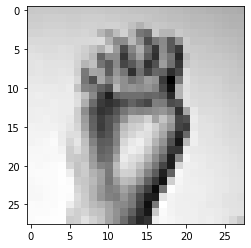

In [ ]:
# Plots Sample ID: 60 in Greyscale
id = 60
test_pic_label = df['label'][id]
test_pic = np.array(df.values[id][1:])
test_pic.resize((28,28))
plt.imshow(test_pic, cmap="gray")
print(test_pic_label)

## Model Architecture

**Convolutional Neural Network**


Our end goal is to be able to classify images that contain hand-signs and label them to the correct corresponding letter. That said, we decided to first try implementing a Convolution Neural Network due to its popularity in image processing. The reason for this is because we can reduce the dimensionality of the image to simplify the image to its most important features or pixels, which increases computation speed without significantly impacting the accuracy of the model (Source: https://medium.datadriveninvestor.com/why-are-convolutional-neural-networks-good-for-image-classification-146ec6e865e8)

**Feed Forward Process**

1. Our neural network starts by taking a 28x28 pixel sized image and applying 16 filters (images are not RGB so just 1 value) of shape 3x3.

2. It then proceeds to the max pooling phase, where the maximum pixel value of every 2x2 grid is used to substitute the 4 pixel values within the 2x2 grid. 

3. The remaining pixels are tied together in what’s called the Fully Connected Layer, and is passed onto the activation function. Here, we decide to try ReLu to mitigate the possibility of the vanishing gradient phenomena. 

4. The gradient Is then used to calculate a set of weights for each layer, and a gradient descent algorithm called Adams is used to minimize the gradients and thus find the optimum set of weights.

In [ ]:
class SignMINSTDataset(Dataset):
  def __init__(self, data, labels):
      self.labels = labels
      self.data = data

  def __len__(self): 
    return len(self.data)

  def __getitem__(self, idx):
    img = np.array(self.data.iloc[[idx]].drop('label', axis=1))
    img.resize((1,28,28))
    label = int(self.data.iloc[[idx]]['label'])

    return img, label

dataset = SignMINSTDataset(df, classes)

In [ ]:
class MyCNN(nn.Module):
    # The init funciton in Pytorch classes is used to keep track of the parameters of the model
    # specifically the ones we want to update with gradient descent + backprop
    # So we need to make sure we keep track of all of them here
    def __init__(self):
        super(MyCNN, self).__init__()
        # layers defined here

        # Make sure you understand what this convolutional layer is doing.
        # E.g., considering looking at help(nn.Conv2D).  Draw a picture of what
        # this layer does to the data.

        # note: image_dims[0] will be 3 as there are 3 color channels (R, G, B)
        num_kernels = 16
        self.conv1 = nn.Conv2d(image_dims[0], num_kernels, kernel_size=3, stride=1, padding=1)

        # Make sure you understand what this MaxPool2D layer is doing.
        # E.g., considering looking at help(nn.MaxPool2d).  Draw a picture of
        # what this layer does to the data.

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # maxpool_output_size is the total amount of data coming out of that
        # layer.  We have an exercise that asks you to explain why the line of
        # code below computes this quantity.
        self.maxpool_output_size = int(num_kernels * (image_dims[1] / 2) * (image_dims[2] / 2))

        # Add on a fully connected layer (like in our MLP)
        # fc stands for fully connected
        fc1_size = 64
        self.fc1 = nn.Linear(self.maxpool_output_size, fc1_size)

        # we'll use this activation function internally in the network
        self.activation_func = torch.nn.ReLU()

        # Convert our fully connected layer into outputs that we can compare to the result
        fc2_size = len(classes)
        self.fc2 = nn.Linear(fc1_size, fc2_size)

        # Note: that the output will not represent the probability of the
        # output being in each class.  The loss function we will use
        # `CrossEntropyLoss` will take care of convering these values to
        # probabilities and then computing the log loss with respect to the
        # true label.  We could break this out into multiple steps, but it turns
        # out that the algorithm will be more numerically stable if we do it in
        # one go.  We have included a cell to show you the documentation for
        # `CrossEntropyLoss` if you'd like to check it out.
        
    # The forward function in the class defines the operations performed on a given input to the model
    # and returns the output of the model
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.activation_func(x)
        # this code flattens the output of the convolution, max pool,
        # activation sequence of steps into a vector
        x = x.view(-1, self.maxpool_output_size)
        x = self.fc1(x)
        x = self.activation_func(x)
        x = self.fc2(x)
        return x

    # The loss function (which we chose to include as a method of the class, but doesn't need to be)
    # returns the loss and optimizer used by the model
    def get_loss(self, learning_rate):
      # Loss function
      loss = nn.CrossEntropyLoss()
      # Optimizer, self.parameters() returns all the Pytorch operations that are attributes of the class
      optimizer = optim.Adam(self.parameters(), lr=learning_rate)
      return loss, optimizer

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


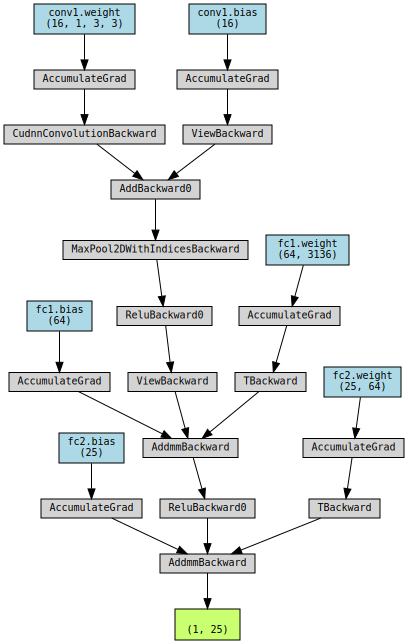

In [ ]:
def visualize_network(net):
    # Visualize the architecture of the model
    # We need to give the net a fake input for this library to visualize the architecture
    fake_input = Variable(torch.zeros((1,image_dims[0], image_dims[1], image_dims[2]))).to(device)
    outputs = net(fake_input)
    # Plot the DAG (Directed Acyclic Graph) of the model
    return make_dot(outputs, dict(net.named_parameters()))

# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

visualize_network(net)

The diagram above visualizes our model archictecture and ends with our output. It's a 1x25 matrix, which contains the probability the test sample corresponds to specific letter.


## Training the Model

Below are the key parameters we use to train the model. 

1.   **Batch Size** - the number of training samples used per iteration
2.   **Learning Rate** - governs the step size for how quickly we can approach the minimum of our loss function
3.   **Number of Epochs** - the number of complete passes through the training set



In [140]:
# Define training parameters
batch_size = 256
learning_rate = 1e-2
n_epochs = 3

# Get our data into the mini batch size that we defined
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [int(len(dataset) * 2 / 3), int(1 + len(dataset) / 3)])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2)


In [141]:
def train_model(net):
    """ Train a the specified network.

        Outputs a tuple with the following four elements
        train_hist_x: the x-values (batch number) that the training set was 
            evaluated on.
        train_loss_hist: the loss values for the training set corresponding to
            the batch numbers returned in train_hist_x
        test_hist_x: the x-values (batch number) that the test set was 
            evaluated on.
        test_loss_hist: the loss values for the test set corresponding to
            the batch numbers returned in test_hist_x
    """ 
    loss, optimizer = net.get_loss(learning_rate)
    # Define some parameters to keep track of metrics
    print_every = 20
    idx = 0
    train_hist_x = []
    train_loss_hist = []
    test_hist_x = []
    test_loss_hist = []

    training_start_time = time.time()
    # Loop for n_epochs
    for epoch in range(n_epochs):
        running_loss = 0.0
        start_time = time.time()

        for i, data in enumerate(train_loader, 0):
            # Get inputs in right form
            inputs, labels = data
            inputs = inputs.type(torch.FloatTensor)
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)
            
            # In Pytorch, We need to always remember to set the optimizer gradients to 0 before we recompute the new gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = net(inputs)
            
            # Compute the loss and find the loss with respect to each parameter of the model
            loss_size = loss(outputs, labels)
            loss_size.backward()
            
            # Change each parameter with respect to the recently computed loss.
            optimizer.step()

            # Update statistics
            running_loss += loss_size.data.item()
            
            # Print every 20th batch of an epoch
            if (i % print_every) == print_every-1:
                print("Epoch {}, Iteration {}\t train_loss: {:.2f} took: {:.2f}s".format(
                    epoch + 1, i+1,running_loss / print_every, time.time() - start_time))
                # Reset running loss and time
                train_loss_hist.append(running_loss / print_every)
                train_hist_x.append(idx)
                running_loss = 0.0
                start_time = time.time()
            idx += 1

        # At the end of the epoch, do a pass on the test set
        total_test_loss = 0
        for inputs, labels in test_loader:

            # Wrap tensors in Variables
            inputs = inputs.type(torch.FloatTensor)
            inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

            # Forward pass
            test_outputs = net(inputs)
            test_loss_size = loss(test_outputs, labels)
            total_test_loss += test_loss_size.data.item()
        test_loss_hist.append(total_test_loss / len(test_loader))
        test_hist_x.append(idx)
        print("Validation loss = {:.2f}".format(
            total_test_loss / len(test_loader)))

    print("Training finished, took {:.2f}s".format(
        time.time() - training_start_time))
    return train_hist_x, train_loss_hist, test_hist_x, test_loss_hist

With our training function created, we can now train our model and record the losses after each batch number.

In [142]:
# Define what device we want to use
device = 'cuda' # 'cpu' if we want to not use the gpu
# Initialize the model, loss, and optimization function
net = MyCNN()
# This tells our model to send all of the tensors and operations to the GPU (or keep them at the CPU if we're not using GPU)
net.to(device)

train_hist_x, train_loss_hist, test_hist_x, test_loss_hist = train_model(net)

Epoch 1, Iteration 20	 train_loss: 306.23 took: 5.30s
Epoch 1, Iteration 40	 train_loss: 3.23 took: 5.09s
Epoch 1, Iteration 60	 train_loss: 3.05 took: 5.05s
Validation loss = 1.83
Epoch 2, Iteration 20	 train_loss: 1.37 took: 5.32s
Epoch 2, Iteration 40	 train_loss: 0.53 took: 5.14s
Epoch 2, Iteration 60	 train_loss: 0.21 took: 5.12s
Validation loss = 0.08
Epoch 3, Iteration 20	 train_loss: 0.06 took: 5.16s
Epoch 3, Iteration 40	 train_loss: 0.04 took: 5.07s
Epoch 3, Iteration 60	 train_loss: 0.03 took: 5.13s
Validation loss = 0.02
Training finished, took 82.80s


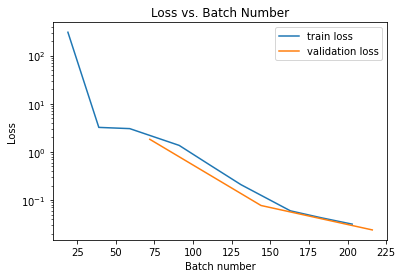

In [143]:
plt.plot(train_hist_x,train_loss_hist)
plt.plot(test_hist_x,test_loss_hist)
plt.title('Loss vs. Batch Number')
plt.legend(['train loss', 'validation loss'])
plt.xlabel('Batch number')
plt.ylabel('Loss')
plt.yscale('log')
plt.show()

The plot above shows positive results! Over the course of our training, our loss function minimizes suggesting that we've reached a near-optimum set of weights.

To prevent overfitting, we reduced the number of epochs to 3, where we observed that the model weights first converged to the minimum gradient.

In [144]:
n_correct = 0
n_total = 0
for i, data in enumerate(train_loader, 0):
    # Get inputs in right form
    inputs, labels = data
    inputs = inputs.type(torch.FloatTensor)
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    # Forward pass
    outputs = net(inputs)
    n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
    n_total += labels.shape[0]
print("Training accuracy is", n_correct/n_total)

n_correct = 0
n_total = 0
for i, data in enumerate(test_loader, 0):
    # Get inputs in right form
    inputs, labels = data
    inputs = inputs.type(torch.FloatTensor)
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    # Forward pass
    outputs = net(inputs)
    n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
    n_total += labels.shape[0]
print("Validation accuracy is", n_correct/n_total)

Training accuracy is 0.9978145659181555
Validation accuracy is 0.9954108391608392


The results above indicate that we've reached nearly 99% training accuracy when testing against the samples we've trained with. This is a good start, but we need to now try this against external test cases to see how well our model works.

### Test data

We also tested this model against the provided test dataset. These images are not present in the training dataset, so the performance from these images should reflect the performance of the algorithm in the real world, though it assumes the algorithm is used in a similar environment as this dataset.

One limitation of this is that the test and training dataset have very similar conditions, such as the skin tone and the background. We will explore this later on.

In [ ]:
test_df = pd.read_csv('sign_mnist_test.csv')
test_df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [ ]:
final_test_dataset = SignMINSTDataset(test_df, classes)
final_test_loader = torch.utils.data.DataLoader(final_test_dataset, batch_size=batch_size, num_workers=2)

In [ ]:
n_correct = 0
n_total = 0
for i, data in enumerate(final_test_loader, 0):
    # Get inputs in right form
    inputs, labels = data
    inputs = inputs.type(torch.FloatTensor)
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    # Forward pass
    outputs = net(inputs)
    n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
    n_total += labels.shape[0]
print("Test accuracy is", n_correct/n_total)

Test accuracy is 0.6972950362520914


As expected, the accuracy is significantly lower than the validation accuracy, found using the training dataset. We have tweaked the training parameters and found the best we can get is around 70%.

## Exploring the Impact of Differing Backgrounds + Skin Tone

We wanted to take some time to consider the potential unwanted impact this algorithm may have if implemented in the real world. This was alluded to a bit In the beginning of the notebook with some of the questions we raised, which were focused mainly on background lighting and diversity of skin tones. During our exploration of the dataset, we noticed that a lot of the pictures were taken with specific lighting, and that all the hands had light skin tones. 

That said, we wanted to see how the model we trained based on this data would respond to hand signs with different lighting/backgrounds as well as darker skin tones. 

As a point of reference, the model tested ~60-70% accurate against the provided testing dataset.

To explore the effects of differing backgrounds/lighting, we then tested against Justin’s hands, which are fairly light toned. As a control, we took four pictures against a white background akin to that of the dataset. As an experimental set, we also took a few pictures with the same hand signs against the window with harsher lighting conditions.

To explore how different skin tones would impact the results, we also set up a second experiment group with a friend who has darker skin, signing the same symbols.


In [ ]:
# Download Self-Collected Data

gdown.download('https://drive.google.com/uc?authuser=0&id=1h2NEr_IWxp1cOnU5gv6YoFGGiLcK1nZ8&export=download', 
               'pictures.zip', quiet=False)
gdown.download('https://drive.google.com/uc?authuser=0&id=1OvOQdxca7KCPoiT7TtjDNGcXTpmiAfvd&export=download', 
               'adi_pictures.zip', quiet=False)

!unzip -qq -o pictures.zip
!unzip -qq -o adi_pictures.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1h2NEr_IWxp1cOnU5gv6YoFGGiLcK1nZ8&export=download
To: /content/pictures.zip
100%|██████████| 50.8k/50.8k [00:00<00:00, 13.4MB/s]
Downloading...
From: https://drive.google.com/uc?authuser=0&id=1OvOQdxca7KCPoiT7TtjDNGcXTpmiAfvd&export=download
To: /content/adi_pictures.zip
100%|██████████| 26.8k/26.8k [00:00<00:00, 6.80MB/s]


In [ ]:
# Unzip and Name of Images
files = [i for i in os.listdir() if 'IMG' in i] + [os.path.join('adi_pictures', i) for i in os.listdir('adi_pictures')]
files

['IMG_2092.png',
 'IMG_2091.png',
 'IMG_2090.png',
 'IMG_2087.png',
 'IMG_2089.png',
 'IMG_2085.png',
 'IMG_2086.png',
 'IMG_2088.png',
 'adi_pictures/adi_d.png',
 'adi_pictures/adi_a.png',
 'adi_pictures/adi_y.png',
 'adi_pictures/adi_b.png']

**Visualize the Control and Two Experiment Groups**

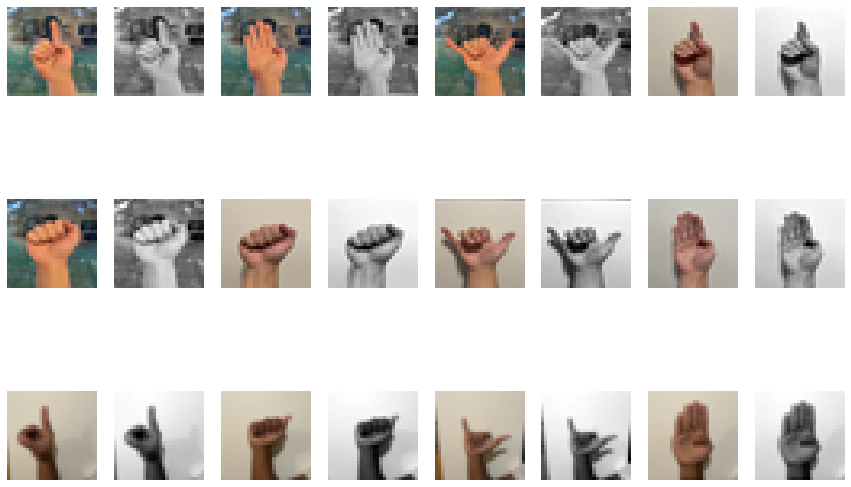

In [131]:
plt.subplots(3, 8, figsize=(15, 10))

df_pictures = pd.DataFrame()

for i, filename in enumerate(files):
    img = cv2.imread(filename)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display RGB images
    plt.subplot(3, 8, i * 2 + 1)
    plt.axis('off')
    plt.imshow(img)

    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Display grey images
    plt.subplot(3, 8, i * 2 + 2)
    plt.axis('off')
    plt.imshow(img, cmap="gray")

    # Add img to dataframe
    img.resize(28*28)
    series = pd.Series(img)
    df_pictures = df_pictures.append(series, ignore_index=True)


In [132]:
# Manually set labels
df_pictures['label'] = [24, 24, 0, 1, 1, 3, 3, 0, 3, 0, 24, 1]
df_pictures.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783,label
0,119.0,177.0,218.0,131.0,105.0,123.0,117.0,110.0,100.0,99.0,101.0,107.0,103.0,107.0,112.0,111.0,104.0,94.0,109.0,116.0,90.0,109.0,106.0,82.0,102.0,164.0,132.0,121.0,189.0,196.0,151.0,100.0,94.0,124.0,121.0,112.0,107.0,104.0,105.0,121.0,...,153.0,157.0,158.0,168.0,152.0,108.0,113.0,115.0,115.0,103.0,107.0,115.0,101.0,108.0,108.0,112.0,107.0,100.0,105.0,101.0,99.0,106.0,95.0,111.0,147.0,145.0,144.0,145.0,152.0,155.0,158.0,163.0,165.0,161.0,156.0,156.0,151.0,146.0,150.0,24
1,79.0,82.0,92.0,167.0,152.0,88.0,93.0,104.0,90.0,92.0,100.0,117.0,107.0,108.0,113.0,111.0,108.0,108.0,99.0,103.0,106.0,83.0,97.0,98.0,78.0,88.0,162.0,124.0,106.0,128.0,174.0,211.0,123.0,82.0,106.0,112.0,105.0,97.0,92.0,93.0,...,162.0,139.0,87.0,96.0,90.0,89.0,89.0,93.0,96.0,99.0,80.0,95.0,97.0,82.0,87.0,91.0,94.0,90.0,83.0,81.0,84.0,131.0,125.0,121.0,124.0,136.0,146.0,151.0,156.0,148.0,139.0,140.0,135.0,134.0,128.0,123.0,124.0,121.0,116.0,24
2,95.0,97.0,99.0,89.0,83.0,73.0,96.0,87.0,80.0,78.0,82.0,93.0,103.0,120.0,136.0,136.0,146.0,147.0,131.0,131.0,133.0,114.0,105.0,112.0,121.0,128.0,95.0,91.0,90.0,81.0,87.0,80.0,79.0,102.0,99.0,68.0,81.0,78.0,73.0,93.0,...,158.0,159.0,158.0,158.0,115.0,90.0,91.0,97.0,109.0,104.0,78.0,95.0,88.0,81.0,74.0,84.0,90.0,89.0,87.0,90.0,80.0,66.0,70.0,124.0,134.0,141.0,147.0,154.0,157.0,157.0,156.0,158.0,131.0,81.0,91.0,93.0,97.0,100.0,98.0,0
3,197.0,196.0,195.0,195.0,196.0,196.0,197.0,197.0,198.0,198.0,198.0,199.0,199.0,200.0,201.0,201.0,201.0,202.0,201.0,201.0,201.0,201.0,201.0,201.0,201.0,201.0,200.0,201.0,193.0,193.0,193.0,193.0,194.0,194.0,195.0,196.0,196.0,197.0,197.0,198.0,...,132.0,133.0,126.0,128.0,172.0,169.0,169.0,169.0,170.0,170.0,171.0,165.0,162.0,161.0,160.0,161.0,161.0,162.0,162.0,163.0,158.0,104.0,103.0,132.0,138.0,140.0,148.0,145.0,137.0,132.0,126.0,120.0,169.0,170.0,170.0,170.0,170.0,171.0,173.0,1
4,84.0,102.0,84.0,75.0,94.0,100.0,65.0,78.0,78.0,77.0,95.0,115.0,116.0,111.0,110.0,120.0,123.0,111.0,114.0,115.0,103.0,101.0,107.0,110.0,109.0,88.0,82.0,65.0,79.0,83.0,109.0,172.0,123.0,75.0,85.0,89.0,82.0,82.0,92.0,105.0,...,161.0,163.0,129.0,78.0,83.0,85.0,89.0,103.0,98.0,79.0,74.0,91.0,77.0,76.0,82.0,80.0,82.0,81.0,74.0,84.0,119.0,118.0,131.0,140.0,148.0,158.0,162.0,162.0,162.0,160.0,141.0,89.0,83.0,89.0,89.0,90.0,98.0,97.0,75.0,1


**Results**

In [135]:
pictures_dataset = SignMINSTDataset(df_pictures, classes)
pictures_loader = torch.utils.data.DataLoader(pictures_dataset, batch_size=1, num_workers=1)

n_correct = 0
n_total = 0
for i, data in enumerate(pictures_loader, 0):
    # Get inputs in right form
    inputs, labels = data
    inputs = inputs.type(torch.FloatTensor)
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    # Forward pass
    outputs = net(inputs)
    print(f"Outputs: {np.argmax(outputs.cpu().detach().numpy(), axis=1)},\tExpected: {int(labels[0])}")
    n_correct += np.sum(np.argmax(outputs.cpu().detach().numpy(), axis=1) == labels.cpu().numpy())
    n_total += labels.shape[0]
print("Picture accuracy is", n_correct/n_total)

Outputs: [3],	Expected: 24
Outputs: [0],	Expected: 24
Outputs: [18],	Expected: 0
Outputs: [23],	Expected: 1
Outputs: [22],	Expected: 1
Outputs: [7],	Expected: 3
Outputs: [19],	Expected: 3
Outputs: [19],	Expected: 0
Outputs: [19],	Expected: 3
Outputs: [6],	Expected: 0
Outputs: [7],	Expected: 24
Outputs: [14],	Expected: 1
Picture accuracy is 0.0


**Interpretation**

The model had great difficulty classifying both groups, and the accuracy quickly plummeted to between 0-12%. It was a bit strange at first seeing the control set accuracy fall to 0%, but we believe this to be a flaw of the original dataset having such specific backgrounds and lighting conditions. If the dataset were more diverse, we’d believe that the model would do better with classifying our collected images.

The same poor results were found when testing the model on the images with hands of a darker skin tone. As shown above, the accuracy remained 0%.

Given that the model was able to classify more than 95% of the training set correctly, and 60-70% of the provided testing set, we believe that these poor accuracy results show that the model is just not robust to images differing in the slightest from the conditions present in the dataset. 


## Additional Visualizations

**Visualizing Filters and the Impact of Convolution**

Beyond exploring the impact of differing backgrounds/lightings and skin tones, we also did some additional visualizations to better understand what the model was doing with the data it was testing on, specifically in the convolution step.


Here, we visualize what the 16 filters applied as convolutions to the images look like. 

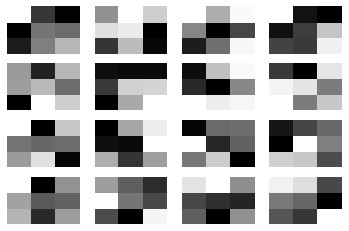

In [138]:
plt.subplots(4, 4)
for i in range(net.conv1.weight.shape[0]):
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    kernel = net.conv1.weight[i].cpu().detach().numpy()
    im = kernel.mean(axis=0)
    plt.pcolor(im, cmap='gray')

The images above show the kernels in color map format (darker being closer to 0, and lighter being higher valued). 

**Visualizing the Convolution and Feature Maps**

Next, we wanted to visualize how the application of these filters changed the incoming images.

In [ ]:
def visualize_convl(net, loader, index=0):
    # Visualize Impact of Convolution
    img = list(loader)[index]
    inputs, labels = img
    inputs = inputs.type(torch.FloatTensor)
    inputs, labels = Variable(inputs).to(device), Variable(labels).to(device)

    y = net.conv1(inputs)

    inputs_display = inputs.cpu().detach().numpy()
    y_display = y.cpu().detach().numpy()

    # print(inputs_display)
    plt.imshow(inputs_display[0][0], cmap='gray')
    plt.title("Before Convolution")
    plt.show()

    plt.figure(figsize=(10, 10))
    for i in range(y.shape[1]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(y_display[0][i], cmap='gray')
        plt.axis('off')
        plt.title(f"Convolution of kernel {i}")

**Visualization of Provided Dataset Image**

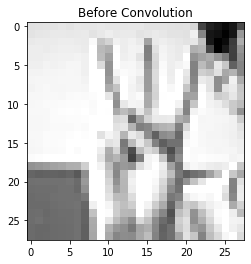

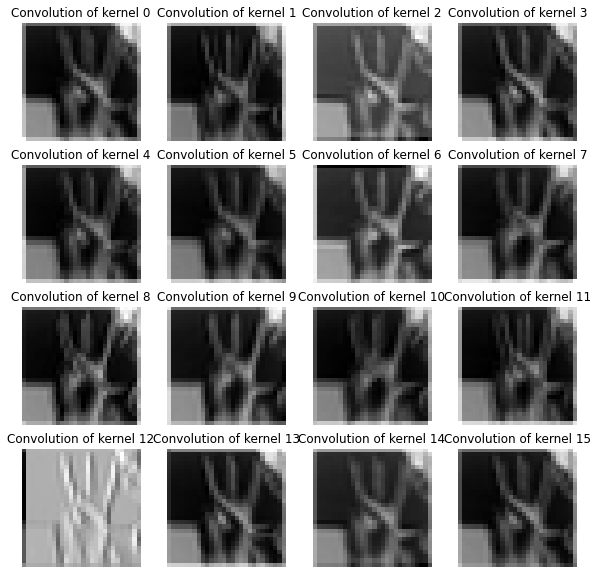

In [ ]:
visualize_convl(net, train_loader)

**Visualization of Justin's Hand Against a White Background**

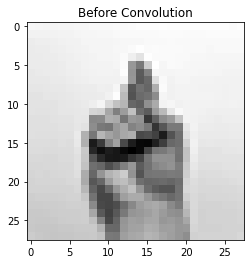

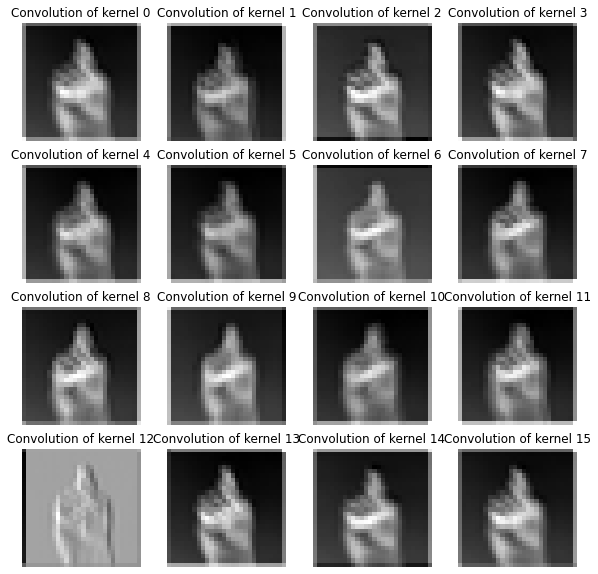

In [ ]:
visualize_convl(net, pictures_loader, index=3)

**Visualization of Justin's Hand Against a Window**

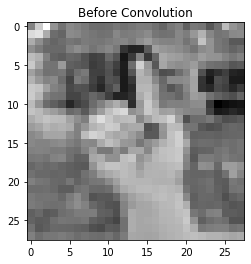

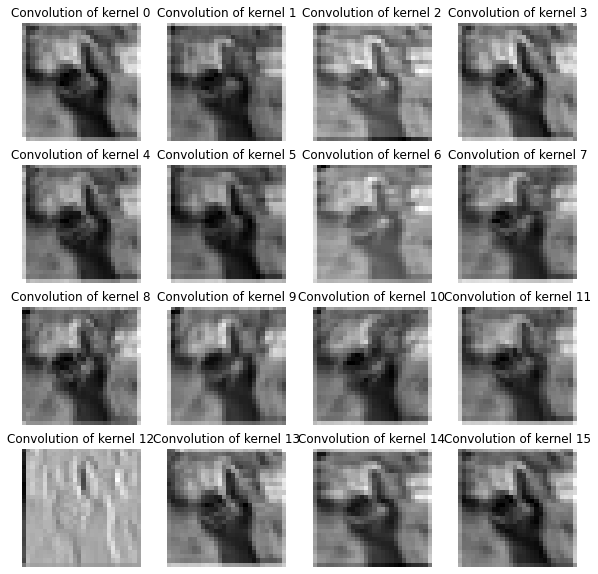

In [ ]:
visualize_convl(net, pictures_loader)

**Visualization of a Friend's Hand Against a White Background**

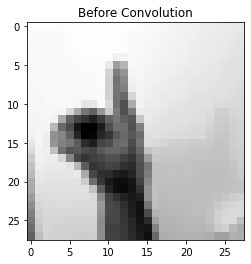

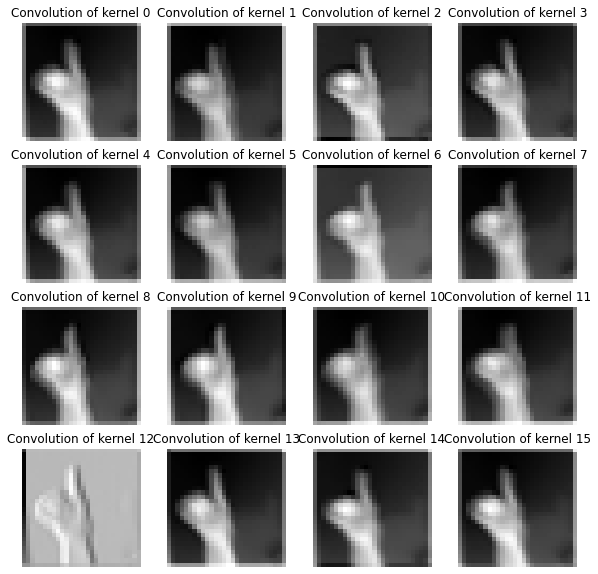

In [ ]:
visualize_convl(net, pictures_loader, index=8)

Looking at the results above, it's quite interesting to compare the difference between our self-taken images and the one originating from the dataset. Despite all images being 28x28 in resolution, the features showing the edges of the hand and fingers are much more prominent (darker) in the original dataset, while majority of the images we took, showed figures with either white edges or pixels fully blended with the rest of the hand. This could be a reason why the model failed to recognize our taken images.

# Conclusion

In this project, we were able to successfully take a dataset online, create and train a Convolutional Neural Network model, and have it classify hand-signed images with decent accuracy. We also explored the robustness of this model by seeing how the accuracy differed when provided hand sign images with differing backgrounds and skin tones. Lastly, we also did a bit more digging and were able to visualize how the convolution step worked in our feed forward loop of the convolutional neural network. 

**Reflecting on Learning Goals**

**Justin**

Coming into this project, my learning goals were to gain more confidence creating ML algorithms through practicing implentation + programming, as well as to scope the project into something small so that we could quickly get a model running and expand upon it. Looking back, I feel comfortable saying I accomplished the second goal and feel that I didn't quite meet the first.

The majority of the assignment was done through pair programming with Wesley taking the lead. This went quite well, and thanks to Wesley's quick programming capabilties and some input from myself here and there, we were able to get a model running pretty quickly. In the meantime, I also focused on writing out the report adjacent to the code.

I had an opportunity to take the lead programming when it came to implementing visualizations. However, I had to forego this due to an unexpected surge of SCOPE work as well as I had become sick towards the end of the project. As a result, my main contributions to this project fell more towards writing the report, gathering new data for experiments, helping brainstorm what visualizations to run, and being a soundboard for Wesley if we were really blocked on code. 

Overall, despite not being able to struggle through the code and practice implementation directly, I still feel happy with the work I put into this project, and the learning that resulted from it.

**Wesley**

We did it! I’m pretty happy with the convolutional neural net we built using pytorch. We spent a significant time wrestling with the data to make the dataset fit into pytorch, and I think I learned a lot about the library this way. I think our biggest challenge was struggling to get the weights to converge. This was before we had a solid understanding of how the neural net trained. However, as we started tweaking different parameters, specifically batch number and learning rate, we learned a lot about how to optimize the training. One thing that we didn’t get a chance to explore was how different amounts of neurons in the hidden layer affects the model’s performance. If we had more time to wrestle with this project, one thing I would like to try is to plot the neural net performance in both accuracy and time as we swept through different sizes of the hidden layer.

I’m really satisfied with this project’s outcome; while I wish we had a little bit more time to play with the model a bit, we accomplished quite a bit and learned a lot.